## Imports

import standard packages

In [4]:
import astropy.table as t
import numpy as np
import matplotlib.pyplot as plt

emcee for the MCMC, chainconsumer for plotting (alternatives could be corner or getdist)

In [5]:
import emcee
import chainconsumer

dynesty for the nested sampling along with its own plotting routines
alternatives for sampling could be e.g. nautilus-sampler, pypolychord, ultranest, multinest

In [158]:
import dynesty #
from dynesty import plotting as dyplot
from dynesty import NestedSampler
import pandas

## 1) basic I/O and plotting

load data

In [9]:
data=t.Table.read('xi_measurement_tutorial8.dat',format='ascii.commented_header')
rng=np.random.default_rng()
theta=data['theta[arcmin]']
xi=data['xi_+(theta)']
cov=np.diag(data['sigma(xi_+(theta))']**2)

compute inverse covariance

In [11]:

invcov=np.linalg.inv(cov)

define the first model, likelihood and prior (those are defined as vector functions to later allow emcee to pass a (Nwalkers, Nparameters) vector which speeds up computations here, but not always)

In [55]:
def model(params,m_theta=theta):
    A,B,alpha=np.atleast_2d(params).T
    m_xi=A[:,np.newaxis]*m_theta**0.5+B[:,np.newaxis]*m_theta**alpha[:,np.newaxis]
    return m_xi
    
def log_prior(params):
    A,B,alpha=params.T
    prior=np.zeros(A.shape)
    prior[np.abs(A)>10]=-np.inf
    prior[np.abs(B)>10]=-np.inf
    prior[(alpha>0.4)|(alpha<0)]=-np.inf
    return prior

def log_like(params,data=xi,d_theta=theta,d_invcov=invcov):
    m=model(params,m_theta=d_theta)
    delta=data[np.newaxis,:]-m  #first index is model pars, second is theta
    logL=-0.5*np.einsum('ij,jk,ik->i',delta,d_invcov,delta)
    return(logL)
    

plot some models

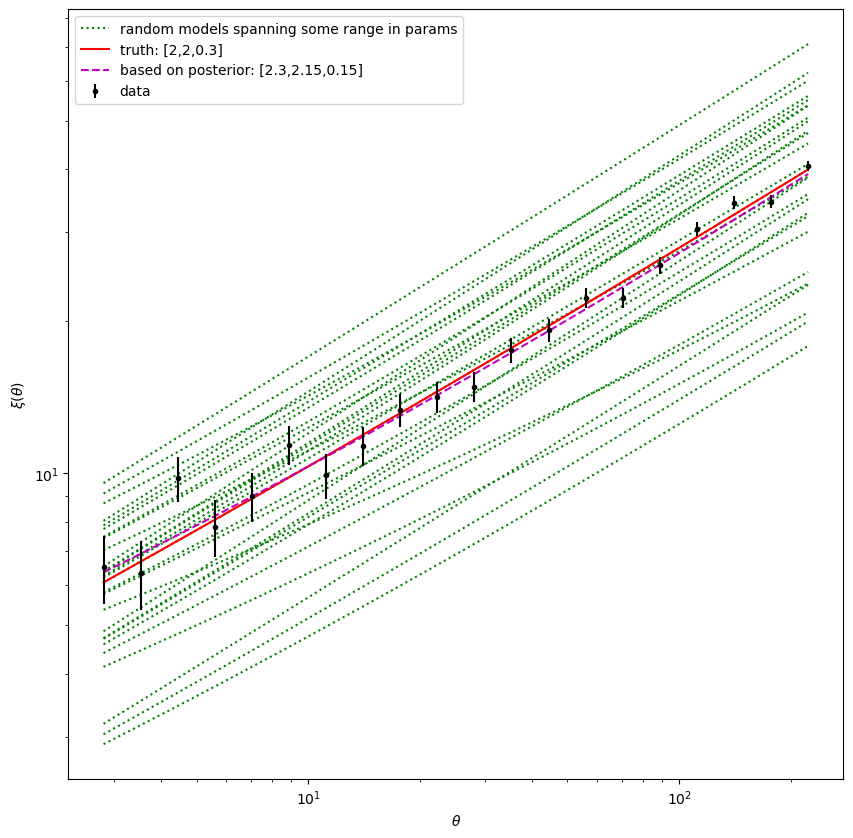

In [14]:
A_vals=np.array([1,2,3])
B_vals=np.array([1,2,3])
alpha_vals=np.array([0.2,0.3,0.4])

A_grid,B_grid,alpha_grid=np.meshgrid(A_vals,B_vals,alpha_vals)
params=np.vstack([A_grid.flatten(),B_grid.flatten(),alpha_grid.flatten()]).T

plt.figure(figsize=(10,10))
plt.errorbar(theta,xi,1,ls='',marker='.',zorder=100,color='k',label='data')
plt.plot(theta,model(params).T,color='g',ls=':',label=['random models spanning some range in params']+[None]*(params.shape[0]-1))
plt.plot(theta,model([2,2,0.3]).T,color='r',label='truth: [2,2,0.3]')
plt.plot(theta,model([2.3,2.15,0.15]).T,color='m',ls='--',label='based on posterior: [2.3,2.15,0.15]')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\xi(\theta)$')
plt.legend()

## 2) main sampling

setup for the sampler

In [94]:
sampler=emcee.EnsembleSampler(nwalkers=100,ndim=3,log_prob_fn=lambda p,d,invcov,theta: log_like(params=p,data=d,d_theta=theta,d_invcov=invcov)+log_prior(p), kwargs=dict(d=xi,invcov=invcov,theta=theta),vectorize=True)

Generate some starting points (emcee recommends to use a small blob of data around a pre-determined max-posterior value here which shows better convergence), I just used a wider range of walkers here

Important things to notice:
- Do not generate starting points outside your prior volume, those walkers might have a hard time to get to the allowed region (the chains still seem to be able to run though in recent emcee versions)
- Emcee is faster in expanding the range covered by walkers than to shrink a large range filled with walkers, that's why a small starting blob is recommended
- Start at some relatively high P(θ|d) region ideally covering the true maximum, moving the whole blob of walkers somewhere else is not efficient either
- Note that running a minimizer can make you start at a local minumum, so it's not guaranteed to prevent the above issues. Sometimes it can be useful to explore the space around an initial minimization with a short chain to then restart in a small blob around the max P(θ|d) (also called MAP) found by the short chain or use other numerical "tricks".

In [95]:
startpoints=rng.uniform(size=(100,3))
startpoints[:,0]-=0.5
startpoints[:,0]*=8
startpoints[:,1]-=0.5
startpoints[:,1]*=8
startpoints[:,2]-=0.5
startpoints[:,2]*=0.2
startpoints[:,2]+=0.2

sampler.run_mcmc(startpoints,20000,progress=True);

100%|██████████| 20000/20000 [00:18<00:00, 1068.93it/s]


this sets up the plotting with `chainconsumer` and grabs chains from the sampler (if you use `corner`, you can pass the chains obtained with `get_chain` into there); `chainconsumer` can be  useful here to e.g. overplot multiple runs and as it allows plotting both nested sampling and MCMC sampling (the `getdist` package can do similar things)

`t` is the autocorrelation time of the chain and according to emcee's manual is a good indicator of chain convergence, discard at least the first max(t) samples (accurate measurements of t might need a long chain though) which we do here via the `discard=...` argument to `get_chain`.

There is a `thin=...` argument to the `get_chain` function which makes long chains more easily usable by removing every N-th sample from the chain. As every sample in a converged chain is an independent draw from the posterior, this does not effect your posterior estimation (except for decreased resolution in parameters).

By default `get_chain` returns an `(Nsteps,Nwalkers,Nparams)` array, but the `flat` argument allows combining things to an `(Nsteps*Nwalkers,Nparams)` array (as required by many plotting routines)

In [96]:
c = chainconsumer.ChainConsumer()
t=sampler.get_autocorr_time()

#those would load the chain directly, but using the chainconsumer fctsbelow
flatchain=sampler.get_chain(flat=True)
no_burnin_flatchain=sampler.get_chain(flat=True,discard=int(np.max(t)))
non_flat_chain=sampler.get_chain(flat=False)

params = ['A','B',r'$\alpha$']
full_chain = chainconsumer.Chain.from_emcee(sampler, params, discard=0, color="b", name='full chain')
no_burnin_chain = chainconsumer.Chain.from_emcee(sampler, params, discard=int(np.max(t)), color="g", show_contour_labels=True, plot_cloud=True,name='after removing burnin')

Compute the maximum a posteriori (MAP) values for each param as well as mean, median and some percentiles

Note that you'd ideally want to quote the smallest region of 68% posterior mass, only for perfectly symmetrical distributions this will be the same as the 16-84 percentile region, only for 1d-Gaussians it will be `mean-std` to `mean+std`; i.e. a better way to get this range is to always sort by posterior probability and assess the boundaries of the region with 68% highest probability inside together with the MAP as the best estimate, we did this on previous sheets, not doing it here, note that none of those estimates actually capture the truth very well and that the MAP actually lies at the boundary of the prior

In [97]:
MAP_ind=np.argmax(sampler.get_log_prob(flat=True))
MAP=flatchain[MAP_ind]
means=np.mean(no_burnin_flatchain,axis=0)
stds=np.std(no_burnin_flatchain,axis=0)
medians=np.median(no_burnin_flatchain,axis=0)
p16s,medians,p84s=np.percentile(no_burnin_flatchain,[16,50,84],axis=0)

print(f"autocorr time: A:{t[0]}, B:{t[0]}, alpha:{t[0]}\n")
print(f"means+-std:\nA: {means[0]}+-{stds[0]}\nB: {means[1]}+-{stds[1]}\nalpha: {means[2]}+-{stds[2]}\n")
print(f"medians+-asymmetrical errorbars:\nA: {medians[0]}+{p84s[0]-medians[0]}-{medians[0]-p16s[0]}\nB: {medians[1]}+{p84s[1]-medians[1]}-{medians[1]-p16s[1]}\nalpha: {medians[2]}+{p84s[2]-medians[2]}-{medians[2]-p16s[2]}\n")
print(f"MAP: A: {MAP[0]}, B: {MAP[1]}, alpha: {MAP[2]}\n")
print(f"truth: A: 2, B: 2, alpha: 0.3")

autocorr time: A:312.3795894103302, B:312.3795894103302, alpha:312.3795894103302

means+-std:
A: 2.3154720784572036+-0.3028190548671911
B: 2.113511124369176+-0.4089893474452877
alpha: 0.1472703821067109+-0.10773592438625706

medians+-asymmetrical errorbars:
A: 2.4167952466462452+0.11890272963025517-0.3231038655624938
B: 2.1035436681291997+0.407936816526171-0.39191562317680284
alpha: 0.12530133085525305+0.14885641973354904-0.09082409711289263

MAP: A: 2.5487315591551054, B: 2.3301555516157215, alpha: 0.0002887560317304527

truth: A: 2, B: 2, alpha: 0.3


actually plot the corner plot, here we show the effect of burn-in on the posterior estimates

In [98]:
c.add_chain(chain=full_chain)
c.add_chain(chain=no_burnin_chain)
c.add_truth(chainconsumer.Truth(location={"A": 2, "B": 2,r'$\alpha$':0.3},name='Truth',color='k', show_label_in_legend=True))
c.add_marker(location={"A":means[0] , "B": means[1],r'$\alpha$':means[2]},name='Mean',color='r', marker_size=30,marker_style='s')
c.add_marker(location={"A":MAP[0] , "B": MAP[1],r'$\alpha$':MAP[2]},name='MAP',color='orange', marker_size=30,marker_style='o')
c.add_marker(location={"A":medians[0] , "B": medians[1],r'$\alpha$':medians[2]},name='Median',color='purple', marker_size=30,marker_style='h')

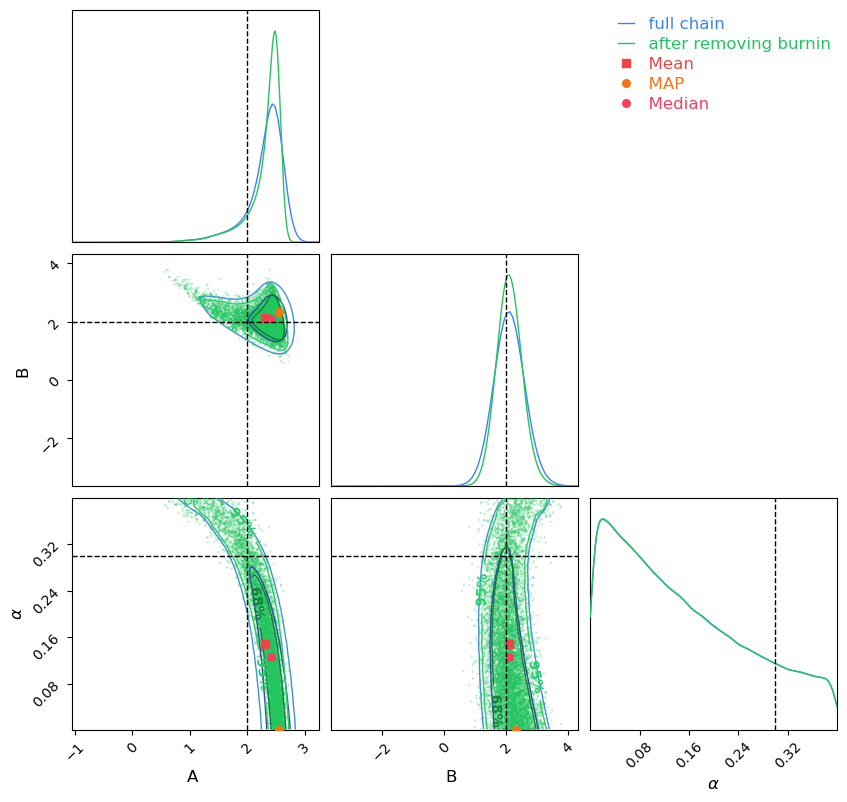

In [99]:
fig_corner=c.plotter.plot();

plot the individual chains as a number of step, this is a typical diagnostics plot and we can see some walkers being stuck at certain parameters for quite a while

Text(0.5, 0, 'step number')

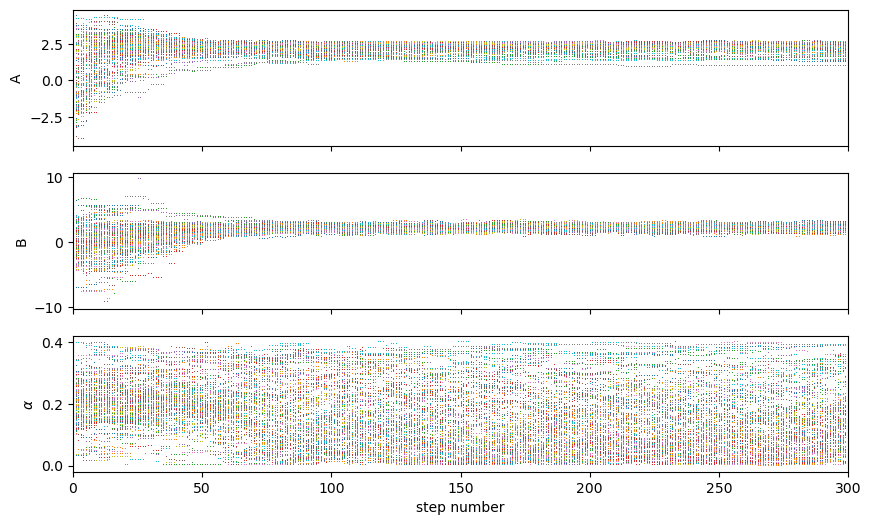

In [100]:
fig,ax = plt.subplots(3,figsize=(10,6),sharex=True)
for i,(a,ch) in enumerate(zip(ax,non_flat_chain.T)):
    a.plot(ch[:100, :1000].T,ls='',marker=',')
    a.set_ylabel(params[i])
ax[-1].set_xlim(0, 300)
ax[-1].set_xlabel("step number")

the same plot using the chainconsumer package without telling the walkers apart and overlaying a smoothed version of the run (thick line) and the truth (dashed line)

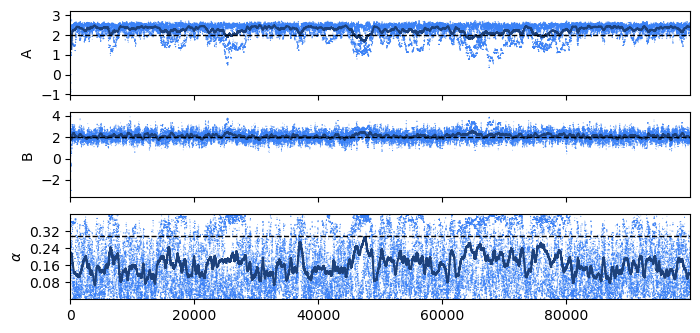

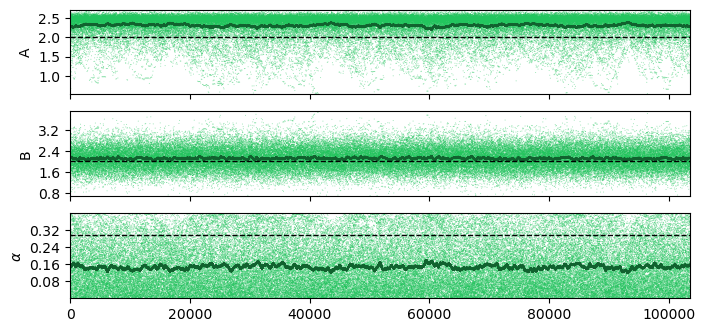

In [101]:
fig_walks=c.plotter.plot_walks(['full chain'],plot_weights=False,convolve=int(np.max(t)));

fig_walks_no_burnin=c.plotter.plot_walks(['after removing burnin'],plot_weights=False,convolve=int(np.max(t)));

### same with a wider prior

here we run the same analysis as before, but with a significantly widened prior range (to see prior volume effects)

In [102]:
def log_prior_wide(params):
    A,B,alpha=params.T
    prior=np.zeros(A.shape)
    prior[np.abs(A)>10]=-np.inf
    prior[np.abs(B)>10]=-np.inf
    prior[np.abs(alpha)>1]=-np.inf
    return prior

this executes things all at once and compares to the previous example in the corner plot

100%|██████████| 20000/20000 [00:18<00:00, 1063.27it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [561.07448505 134.36225211 287.90347689]


autocorr time: A:561.074485048675, B:561.074485048675, alpha:561.074485048675

means+-std:
A: 2.570076530582477+-0.9849196510658688
B: 3.4714724974924653+-1.7830389813999739
alpha: -0.2064166522030317+-0.32026826380840406

medians+-asymmetrical errorbars:
A: 2.663181597827673+0.08275532948033737-0.18886897756171406
B: 3.205751271156692+1.8239794028481766-1.0697758980897034
alpha: -0.21629171540215877+0.32007142226664537-0.3067086354019365

MAP: A: 2.39369756204816, B: 2.9076259440308783, alpha: 0.04465180998492768

truth: A: 2, B: 2, alpha: 0.3


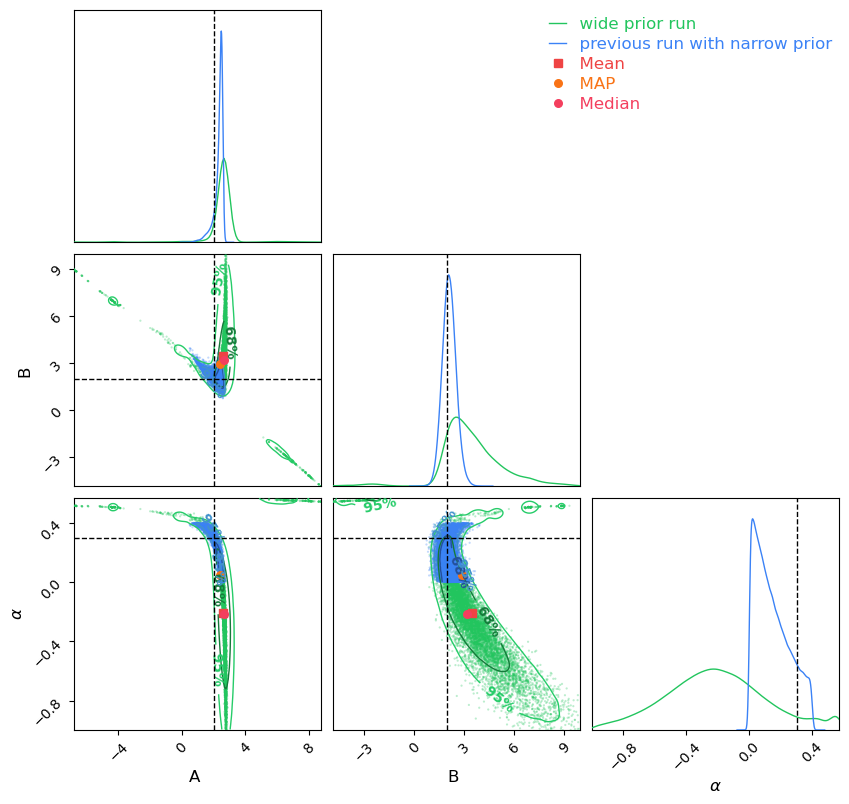

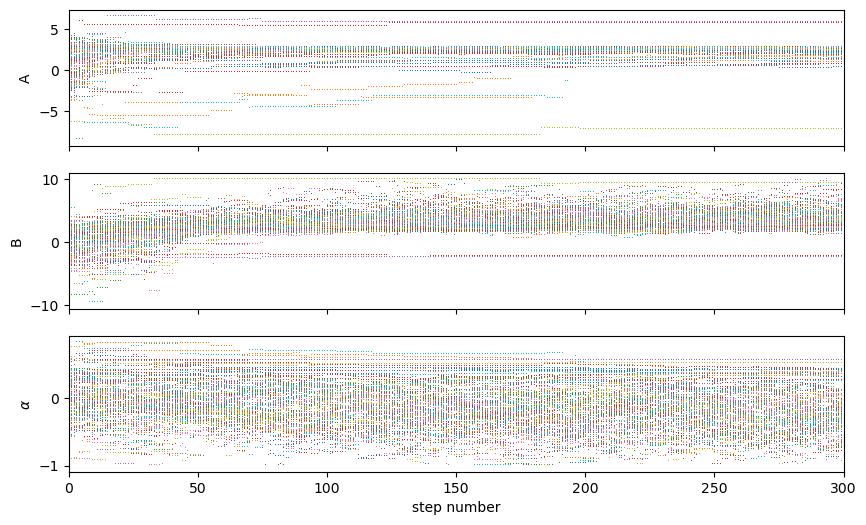

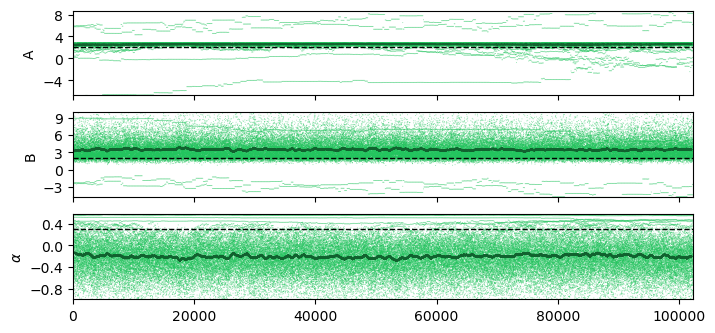

In [107]:
sampler2=emcee.EnsembleSampler(nwalkers=100,ndim=3,log_prob_fn=lambda p,d,invcov,theta: log_like(params=p,data=d,d_theta=theta,d_invcov=invcov)+log_prior_wide(p), kwargs=dict(d=xi,invcov=invcov,theta=theta),vectorize=True)


startpoints2=rng.uniform(size=(100,3))
startpoints2[:,0]-=0.5
startpoints2[:,0]*=8
startpoints2[:,1]-=0.5
startpoints2[:,1]*=8
startpoints2[:,2]-=0.5
startpoints2[:,2]*=1.2

sampler2.run_mcmc(startpoints2,20000,progress=True);

c = chainconsumer.ChainConsumer()
t=sampler2.get_autocorr_time(quiet=True)  #quiet=True is used here, as the autocorr time estimate is not actually converged

flatchain=sampler2.get_chain(flat=True)
no_burnin_flatchain=sampler2.get_chain(flat=True,discard=int(np.max(t)))
non_flat_chain=sampler2.get_chain(flat=False)

wide_prior_chain = chainconsumer.Chain.from_emcee(sampler2, params, discard=int(np.max(t)), color="g", show_contour_labels=True, plot_cloud=True,name='wide prior run')
narrow_prior_chain = chainconsumer.Chain.from_emcee(sampler, params, discard=int(np.max(t)), color="b", show_contour_labels=True, plot_cloud=True,name='previous run with narrow prior')


MAP_ind=np.argmax(sampler.get_log_prob(flat=True))
MAP=flatchain[MAP_ind]
means=np.mean(no_burnin_flatchain,axis=0)
stds=np.std(no_burnin_flatchain,axis=0)
medians=np.median(no_burnin_flatchain,axis=0)
p16s,medians,p84s=np.percentile(no_burnin_flatchain,[16,50,84],axis=0)

print(f"autocorr time: A:{t[0]}, B:{t[0]}, alpha:{t[0]}\n")
print(f"means+-std:\nA: {means[0]}+-{stds[0]}\nB: {means[1]}+-{stds[1]}\nalpha: {means[2]}+-{stds[2]}\n")
print(f"medians+-asymmetrical errorbars:\nA: {medians[0]}+{p84s[0]-medians[0]}-{medians[0]-p16s[0]}\nB: {medians[1]}+{p84s[1]-medians[1]}-{medians[1]-p16s[1]}\nalpha: {medians[2]}+{p84s[2]-medians[2]}-{medians[2]-p16s[2]}\n")
print(f"MAP: A: {MAP[0]}, B: {MAP[1]}, alpha: {MAP[2]}\n")
print(f"truth: A: 2, B: 2, alpha: 0.3")

c.add_chain(chain=wide_prior_chain)
c.add_chain(chain=narrow_prior_chain)
c.add_truth(chainconsumer.Truth(location={"A": 2, "B": 2,r'$\alpha$':0.3},name='Truth',color='k', show_label_in_legend=True))
c.add_marker(location={"A":means[0] , "B": means[1],r'$\alpha$':means[2]},name='Mean',color='r', marker_size=30,marker_style='s')
c.add_marker(location={"A":MAP[0] , "B": MAP[1],r'$\alpha$':MAP[2]},name='MAP',color='orange', marker_size=30,marker_style='o')
c.add_marker(location={"A":medians[0] , "B": medians[1],r'$\alpha$':medians[2]},name='Median',color='purple', marker_size=30,marker_style='h')


fig_corner=c.plotter.plot();

fig,ax = plt.subplots(3,figsize=(10,6),sharex=True)
for i,(a,ch) in enumerate(zip(ax,non_flat_chain.T)):
    a.plot(ch[:100, :1000].T,ls='',marker=',')
    a.set_ylabel(params[i])
ax[-1].set_xlim(0, 300)
ax[-1].set_xlabel("step number")

fig_walks=c.plotter.plot_walks(['wide prior run'],plot_weights=False,convolve=int(np.max(t)));

Note the very different behaviours here, e.g. for $\alpha=0.5$ A and B are fully degenerate (the model only depends on $A+B$ for this case), causing the scattered $A=-B$ area in the contour plots; also for very negative $\alpha$ the B parameter becomes meaningless as that term will evaluate to $\approx 0$

In the walker plot we can also see that we haven't discarded enough burn-in here (see the correlated walking in A,B at steps 0-100 after discarding) and that many walkers are staying in the same region for extended amounts of time without moving back to the bulk of walkers

## 3) change model and add term to covar

generate samples in the nuisance parameter by first sampling B and alpha and computing the nuisance covariance from here (the determinant will be needed later for the nested sampling)

In [108]:
samples_B=rng.uniform(-10,10,10000)
samples_alpha=rng.uniform(0,0.4,10000)
#samples_nuisance=samples_B[:,np.newaxis]*xi[np.newaxis,:]**samples_alpha[:,np.newaxis]    #alternative way to compute the same thing as below
samples_nuisance=samples_B*np.power.outer(xi,samples_alpha)
C_nuisance=np.cov(samples_nuisance)

cov2=cov+C_nuisance
invcov2=np.linalg.inv(cov2)
detinvcov2=np.linalg.det(invcov2)

define the model (not using the vectorization here, the 1d model is quicker to converge anyway)

In [110]:
def model2(params,m_theta=theta):
    A=params
    m_xi=A*m_theta**0.5
    return m_xi

def log_prior2(params):
    A=params
    if np.abs(A)>10: return -np.inf
    return 0
    
def log_like2(params,data=xi,d_theta=theta,d_invcov=invcov2):
    m=model2(params,m_theta=d_theta)
    delta=data[np.newaxis,:]-m
    logL=-0.5*np.einsum('ij,jk,ik->i',delta,d_invcov,delta)
    return(logL)


100%|██████████| 5000/5000 [00:35<00:00, 142.81it/s]


autocorr time: A:24.941810424641133

means+-std:
A: 2.224079538146142+-0.9849196510658688

medians+-asymmetrical errorbars:
A: 2.663181597827673+0.08275532948033737-0.18886897756171406

MAP: A: 2.2244200788918924

truth: A: 2, B: 2, alpha: 0.3


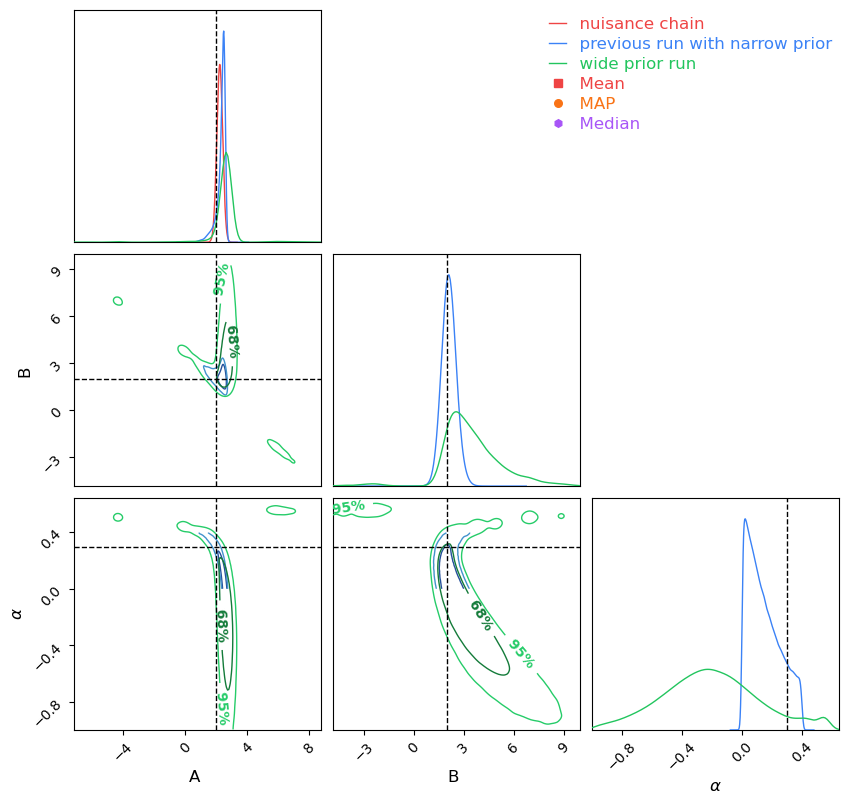

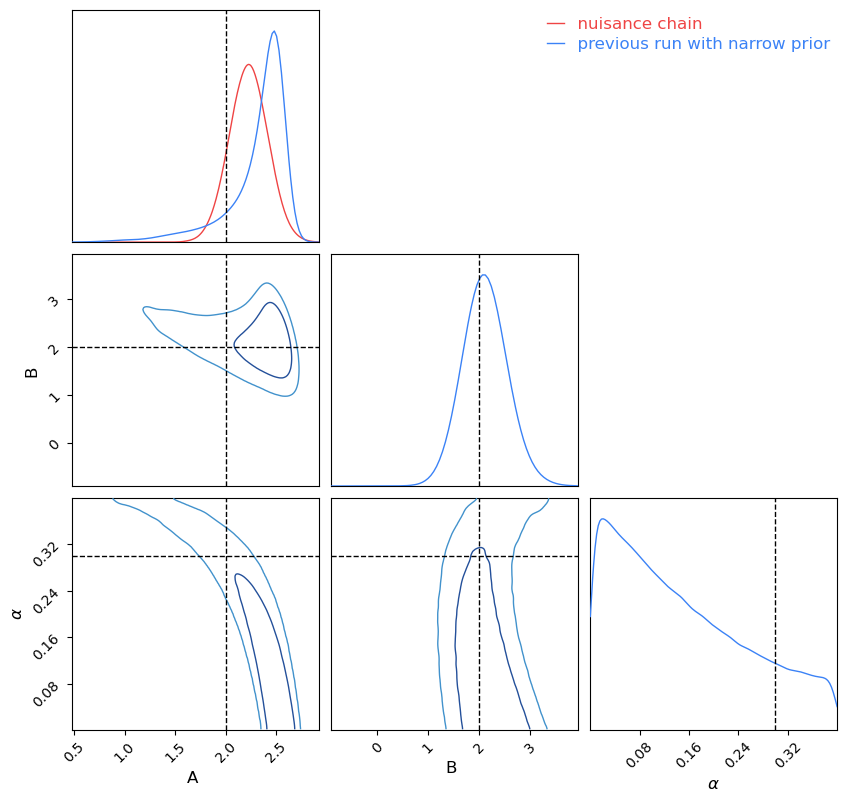

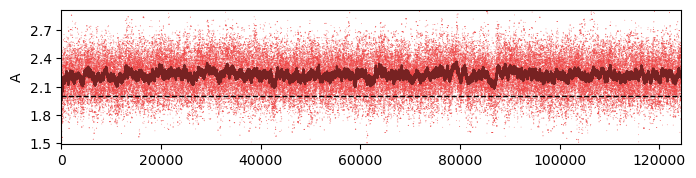

In [154]:
sampler3=emcee.EnsembleSampler(nwalkers=100,ndim=1,log_prob_fn=lambda p,d,invcov,theta: log_like2(params=p,data=d,d_theta=theta,d_invcov=invcov)+log_prior2(p), kwargs=dict(d=xi,invcov=invcov2,theta=theta),vectorize=False)

startpoints3=rng.uniform(size=(100,1))
startpoints3-=0.5
startpoints3*=5

sampler3.run_mcmc(startpoints3,5000,progress=True);

c = chainconsumer.ChainConsumer()
t=sampler3.get_autocorr_time()

#those would load the chain directly, but using the chainconsumer fctsbelow
flatchain=sampler3.get_chain(flat=True)
no_burnin_flatchain=sampler3.get_chain(flat=True,discard=int(np.max(t)))
non_flat_chain=sampler3.get_chain(flat=False)

nuisance_chain = chainconsumer.Chain.from_emcee(sampler3, params[0], discard=int(np.max(t)), color="r", show_contour_labels=False, plot_cloud=True,name='nuisance chain')

wide_prior_chain = chainconsumer.Chain.from_emcee(sampler2, params, discard=int(np.max(t)), color="g", show_contour_labels=True,name='wide prior run')
narrow_prior_chain = chainconsumer.Chain.from_emcee(sampler, params, discard=int(np.max(t)), color="b", show_contour_labels=False,name='previous run with narrow prior')

MAP_ind=np.argmax(sampler3.get_log_prob(flat=True))
MAP=flatchain[MAP_ind]
means=np.mean(no_burnin_flatchain,axis=0)

print(f"autocorr time: A:{t[0]}\n")
print(f"means+-std:\nA: {means[0]}+-{stds[0]}\n")
print(f"medians+-asymmetrical errorbars:\nA: {medians[0]}+{p84s[0]-medians[0]}-{medians[0]-p16s[0]}\n")
print(f"MAP: A: {MAP[0]}\n")
print(f"truth: A: 2, B: 2, alpha: 0.3")

c.add_chain(chain=nuisance_chain)
c.add_chain(chain=narrow_prior_chain)
c.add_chain(chain=wide_prior_chain)

c.add_truth(chainconsumer.Truth(location={"A": 2, "B": 2,r'$\alpha$':0.3},name='Truth',color='k', show_label_in_legend=True))
c.add_marker(location={"A":means[0]},name='Mean',color='r', marker_size=30,marker_style='s')
c.add_marker(location={"A":MAP[0]},name='MAP',color='orange', marker_size=30,marker_style='o')
c.add_marker(location={"A":medians[0] },name='Median',color='purple', marker_size=30,marker_style='h')

fig_corner=c.plotter.plot();
fig_corner=c.plotter.plot(['nuisance chain','previous run with narrow prior']);

fig_walks=c.plotter.plot_walks(['nuisance chain'],plot_weights=False,convolve=int(np.max(t)));


The nuisance chain seems to be getting a better estimate of A than the full model + marginalization, although still $\sim 1-\sigma$, most of the nuisance impact is now absorbed in wider parameter contours

## 4) nested sampling with B term

The nested sampler we're using here starts by drawing numbers from the unit cube, those are transformed to the actual prior range of interest by the following function

In [118]:
# Define our uniform prior via the prior transform.
def ptform(u):
    x = 2. * u - 1.   #center all around 0
    x[0]*=10 #rescale A
    x[1]*=10 #rescale B
    x[2]*=0.2 #rescale alpha
    x[2]+=0.2 #shift alpha so the center is 0.2
    return x



define the likelihood, here we need to take care about the normalization factors that can be ignored in MCMC runs (MCMC only needs P(θ_1)/P(θ_2) but the nested sampler needs the actual normalized likelihood)

setup the nested sampler using this likelihood and 1500 live points, see https://dynesty.readthedocs.io/en/stable/ for what the other params mean

In [119]:
ndim=3

# initialize our nested sampler
def log_like_nested(params,data=xi,d_theta=theta,d_invcov=invcov,d_invdet=np.linalg.det(invcov)):
    m=model(params,m_theta=d_theta)
    delta=data-m[0,:]
    logL=-0.5*np.einsum('j,jk,k',delta,d_invcov,delta)
    lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(d_invdet))
    return(logL)
nested = NestedSampler(log_like_nested, ptform, ndim, nlive=1500,logl_kwargs=dict(data=xi,d_theta=theta,d_invcov=invcov,d_invdet=np.linalg.det(invcov)), bound='balls',
              bootstrap=50, update_interval=1.2)

run the sampler until a convergence criterion is reached

In [120]:
nested.run_nested()
nested_results = nested.results

13108it [06:43, 32.47it/s, +1500 | bound: 25 | nc: 1 | ncall: 98844 | eff(%): 15.007 | loglstar:   -inf < -10.306 <    inf | logz: -19.388 +/-  0.083 | dlogz:  0.001 >  1.509]


show summarizing info about the run

In [121]:
nested_results.summary()

Summary
nlive: 1500
niter: 13108
ncall: 97344
eff(%): 15.007
logz: -19.388 +/-  0.220


plot the likelihood, evidence and importance weights of the samples with time

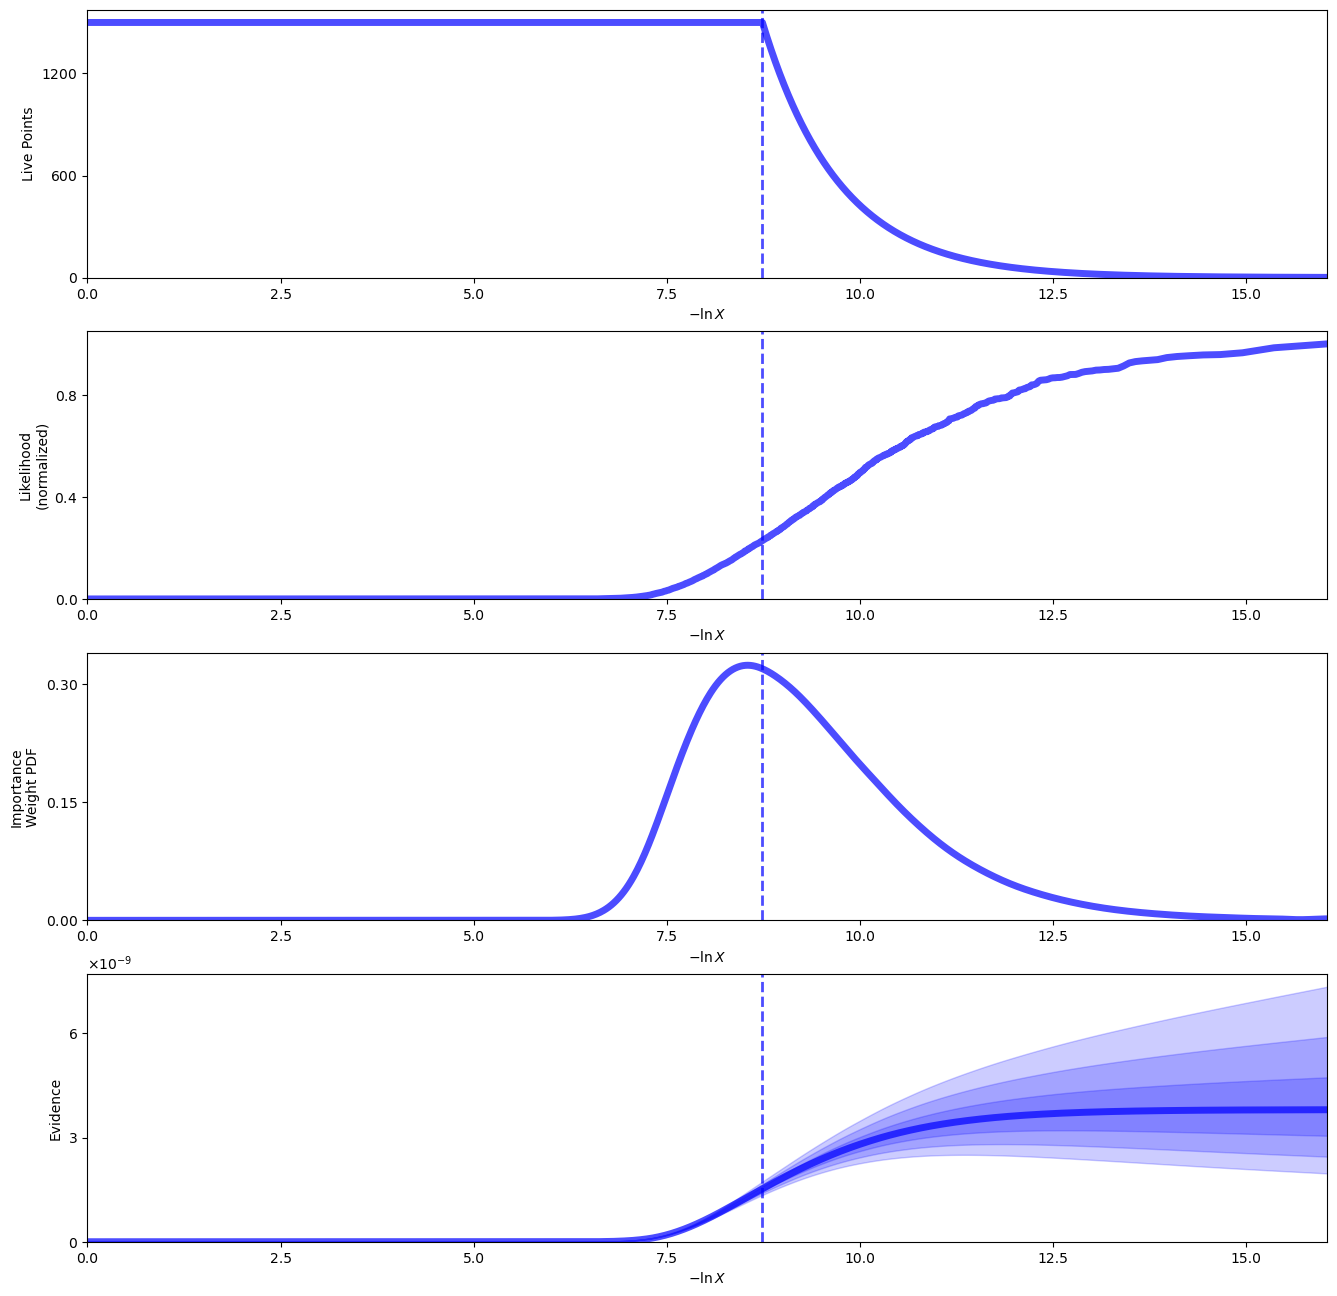

In [122]:
fig, axes = dyplot.runplot(nested_results)  # summary (run) plot

plot the evolution of samples by parameter with time and 1d-posterior histograms (coloring on the left plot is the importance weight, i.e. yellow points contribute most of the posterior)

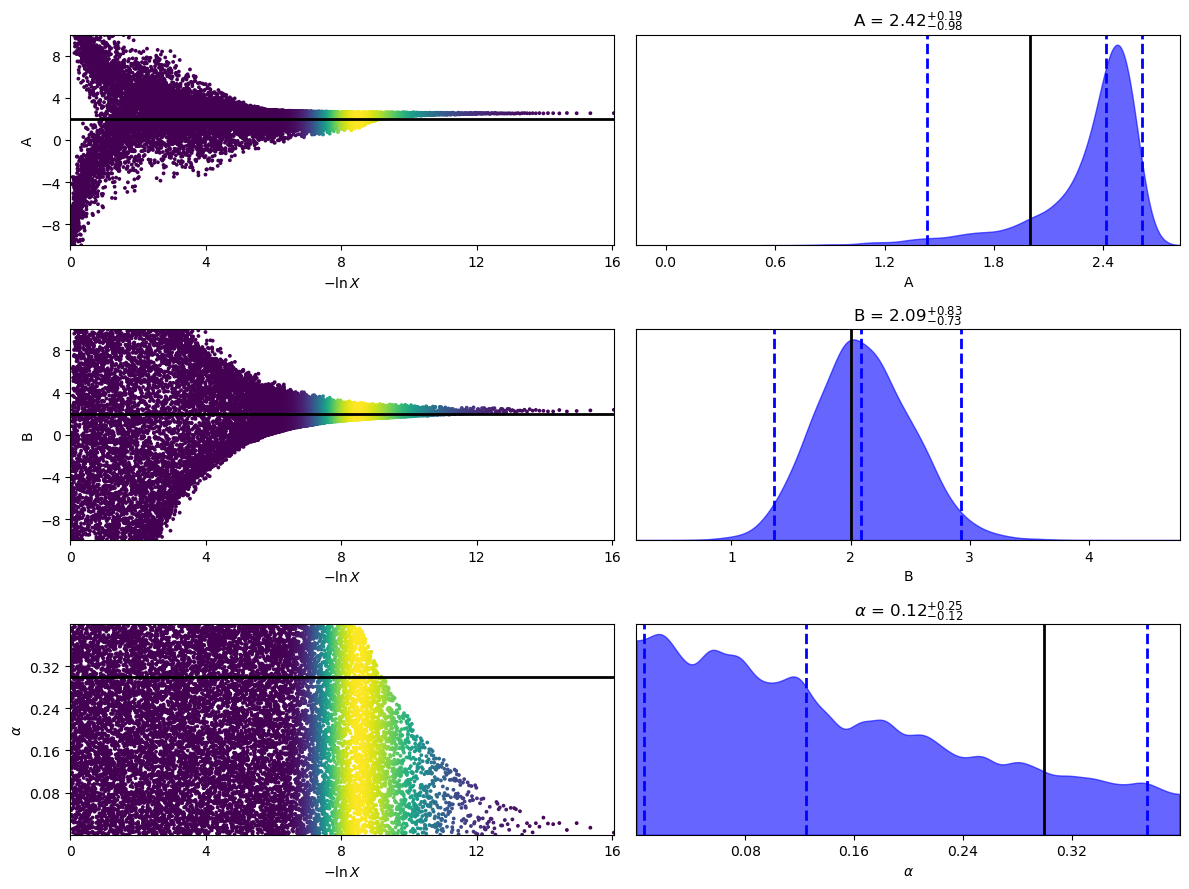

In [128]:
fig, axes = dyplot.traceplot(nested_results, truths=[2,2,0.3],
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis',
                             labels=params)
fig.tight_layout()

plot the distribution of points colored by importance weight as a corner plot

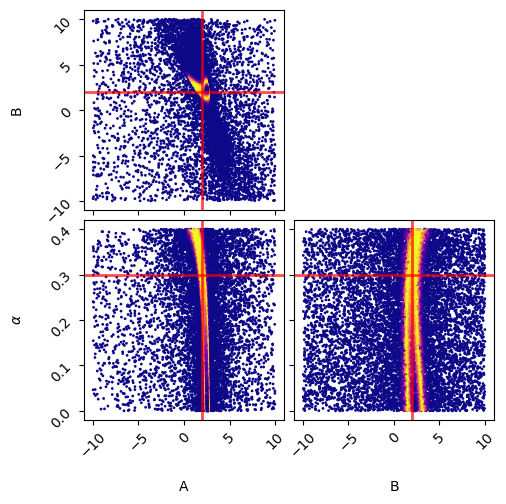

In [124]:
# plot initial run (res1; left)
fg, ax = dyplot.cornerpoints(nested_results, labels=params, cmap='plasma', truths=[2,2,0.3])


plot the posterior probability as a corner plot

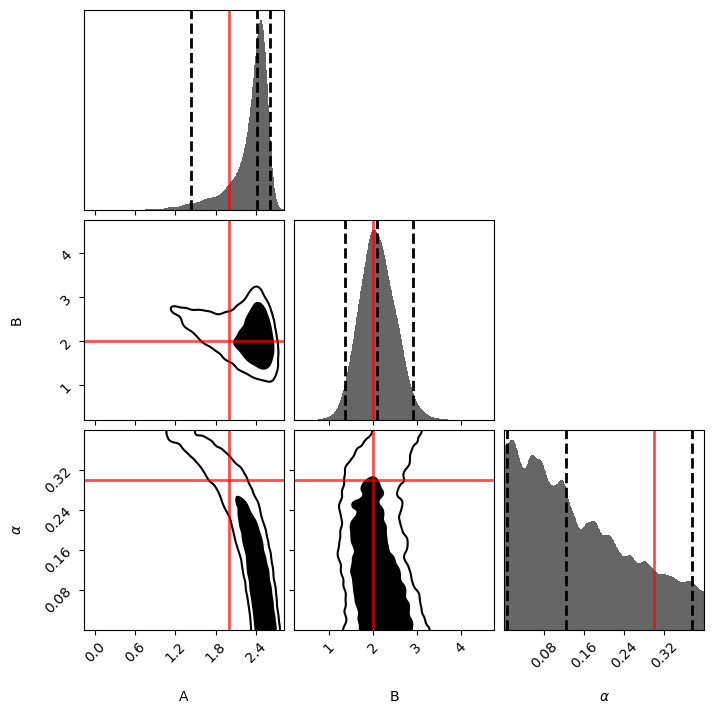

In [129]:
fg, ax = dyplot.cornerplot(nested_results, labels=params, truths=[2,2,0.3],quantiles_2d=[0.68,0.95])

plot the plot the bounding distribution with time (grey are points drawn for the timestep, purple are points kept). We can see that in the early stages, points are drawn from the original prior, while later points are drawn from a smaller area

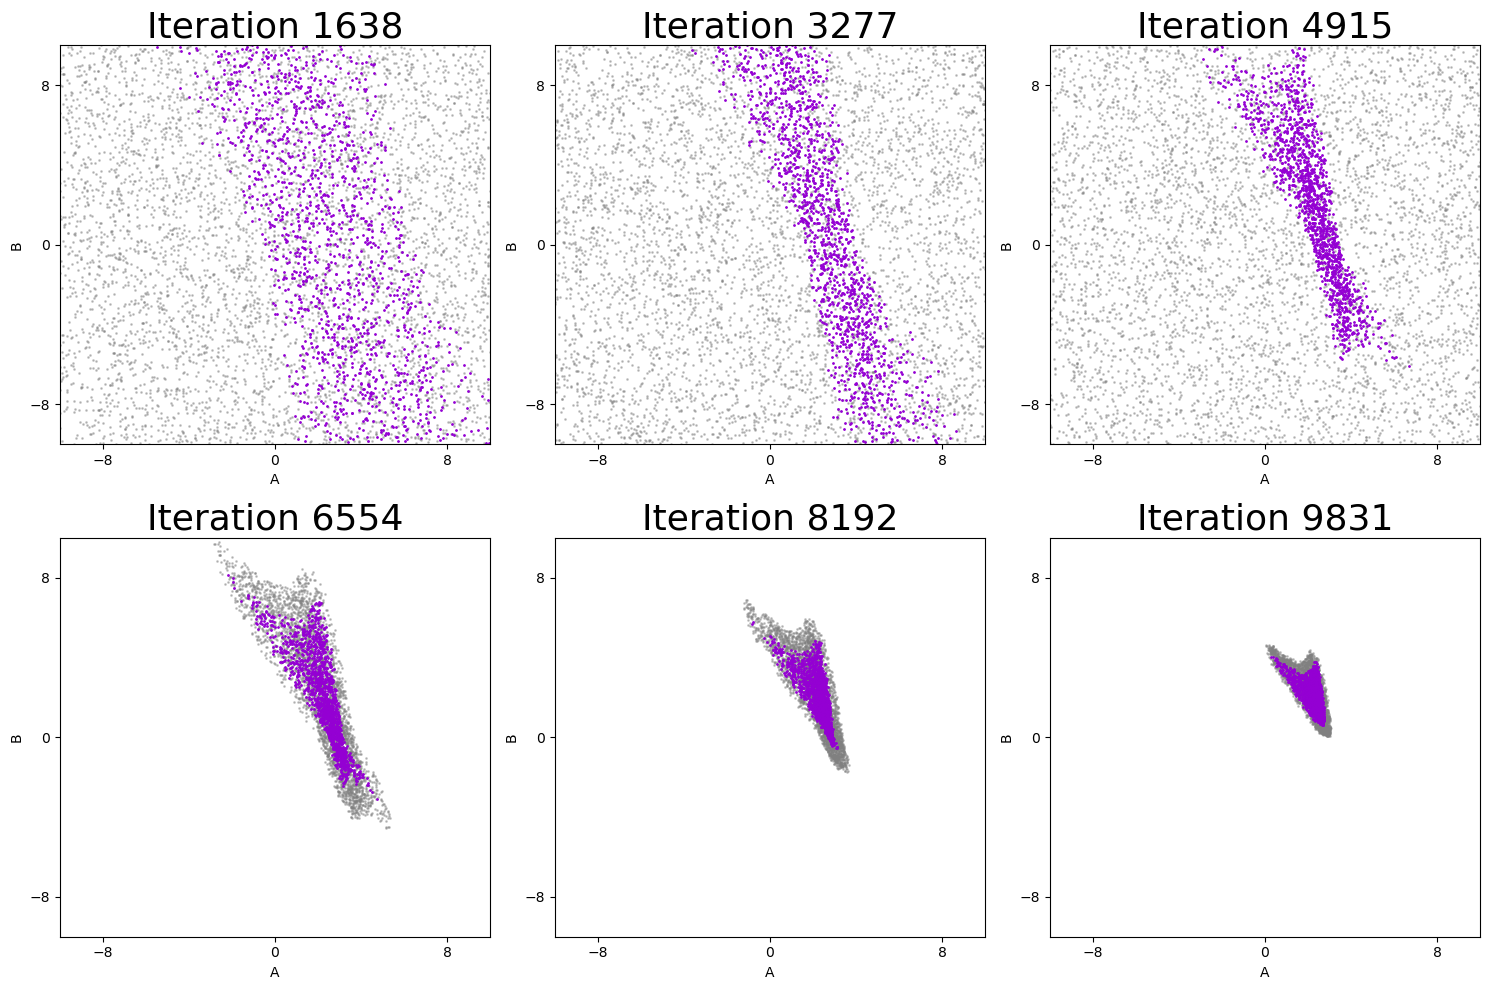

In [130]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# plot 6 snapshots over the course of the run
for i, a in enumerate(axes.flatten()):
    it = int((i+1)*nested_results.niter/8.)
    # overplot the result onto each subplot
    temp = dyplot.boundplot(nested_results, dims=(0, 1), it=it,
                            prior_transform=ptform,
                            max_n_ticks=3, show_live=True,
                            span=[(-10, 10), (-10, 10)],
                            fig=(fig, a),labels=['A','B'])
    a.set_title('Iteration {0}'.format(it), fontsize=26)
fig.tight_layout()


#same for the other param combinations below
#fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# plot 6 snapshots over the course of the run
#for i, a in enumerate(axes.flatten()):
#    it = int((i+1)*nested_results.niter/8.)
#    # overplot the result onto each subplot
#    temp = dyplot.boundplot(nested_results, dims=(1, 2), it=it,
#                            prior_transform=ptform,
#                            max_n_ticks=3, show_live=True,
#                            span=[(-10, 10), (0, 0.4)],
#                            fig=(fig, a),labels=['B',r'$\alpha$'])
#    a.set_title('Iteration {0}'.format(it), fontsize=26)
#fig.tight_layout()

#plot the bounding distribution with time
#fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# plot 6 snapshots over the course of the run
#for i, a in enumerate(axes.flatten()):
#    it = int((i+1)*nested_results.niter/8.)
#    # overplot the result onto each subplot
#    temp = dyplot.boundplot(nested_results, dims=(0, 2), it=it,
#                            prior_transform=ptform,
#                            max_n_ticks=3, show_live=True,
#                            span=[(-10, 10), (0, 0.4)],
#                            fig=(fig, a),labels=['A',r'$\alpha$'])
#    a.set_title('Iteration {0}'.format(it), fontsize=26)
#fig.tight_layout()

compare nested sampling chain to MCMC chains resulting in the same answer as with the MCMC (but using 100k likelihood calls instead of 20 million, the overheads of the sampler basically ate up this advantage)

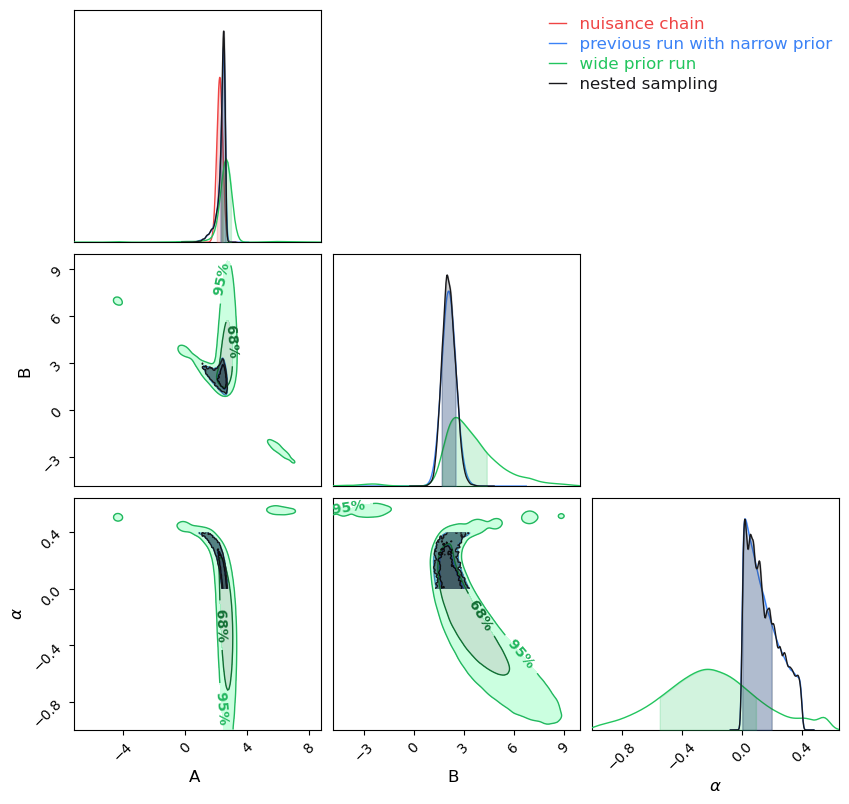

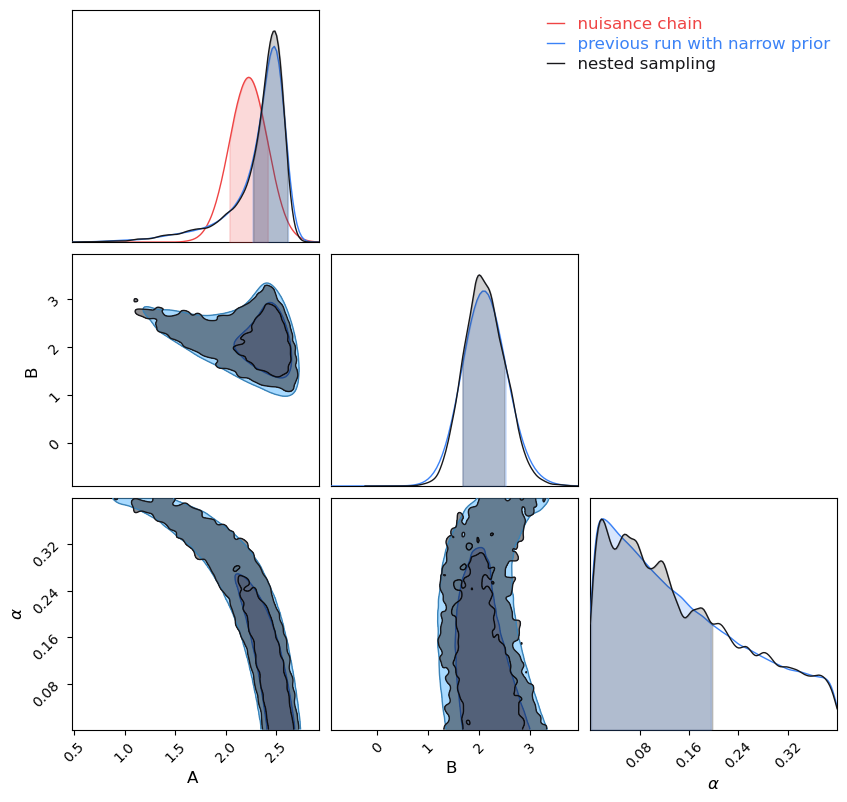

In [165]:
samples, weights = nested_results.samples, nested_results.importance_weights()
nested_chain_pd=pandas.DataFrame(np.hstack([samples,weights[:,np.newaxis]]),columns=params+['weights'])
nested_chain_pd=nested_chain_pd[nested_chain_pd['weights']>0]
nested_chain=chainconsumer.Chain(samples=nested_chain_pd,name='nested sampling',weight_column='weights',color='k')

c = chainconsumer.ChainConsumer()
c.add_chain(chain=nuisance_chain)
c.add_chain(chain=narrow_prior_chain)
c.add_chain(chain=wide_prior_chain)
c.add_chain(chain=nested_chain)
c.plotter.plot();
c.plotter.plot(['nuisance chain','previous run with narrow prior','nested sampling']);

## 4) nested sampling without B term

In [166]:
# Define our uniform prior via the prior transform.
def ptform2(u):
    x = 2. * u - 1.   #center all around 0
    x*=10 #rescale A
    return x

In [167]:
ndim=1
# initialize our nested sampler
def log_like_nested2(params,data=xi,d_theta=theta,d_invcov=invcov,d_invdet=np.linalg.det(invcov)):
    m=model2(params,m_theta=d_theta)
    delta=data-m
    logL=-0.5*np.einsum('j,jk,k',delta,d_invcov,delta)
    lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(d_invdet))
    return(logL)

nested2 = NestedSampler(log_like_nested2, ptform2, ndim, nlive=5000,logl_kwargs=dict(data=xi,d_theta=theta,d_invcov=invcov2,d_invdet=detinvcov2))

In [168]:
nested2.run_nested()
nested_results2 = nested2.results

15298it [00:11, 1388.26it/s, +5000 | bound: 0 | nc: 1 | ncall: 111977 | eff(%): 18.974 | loglstar:   -inf < -8.814 <    inf | logz: -12.557 +/-    nan | dlogz:  0.000 >  5.009]


In [169]:
nested_results2.summary()

Summary
nlive: 5000
niter: 15298
ncall: 106977
eff(%): 18.974
logz: -12.557 +/-  0.106


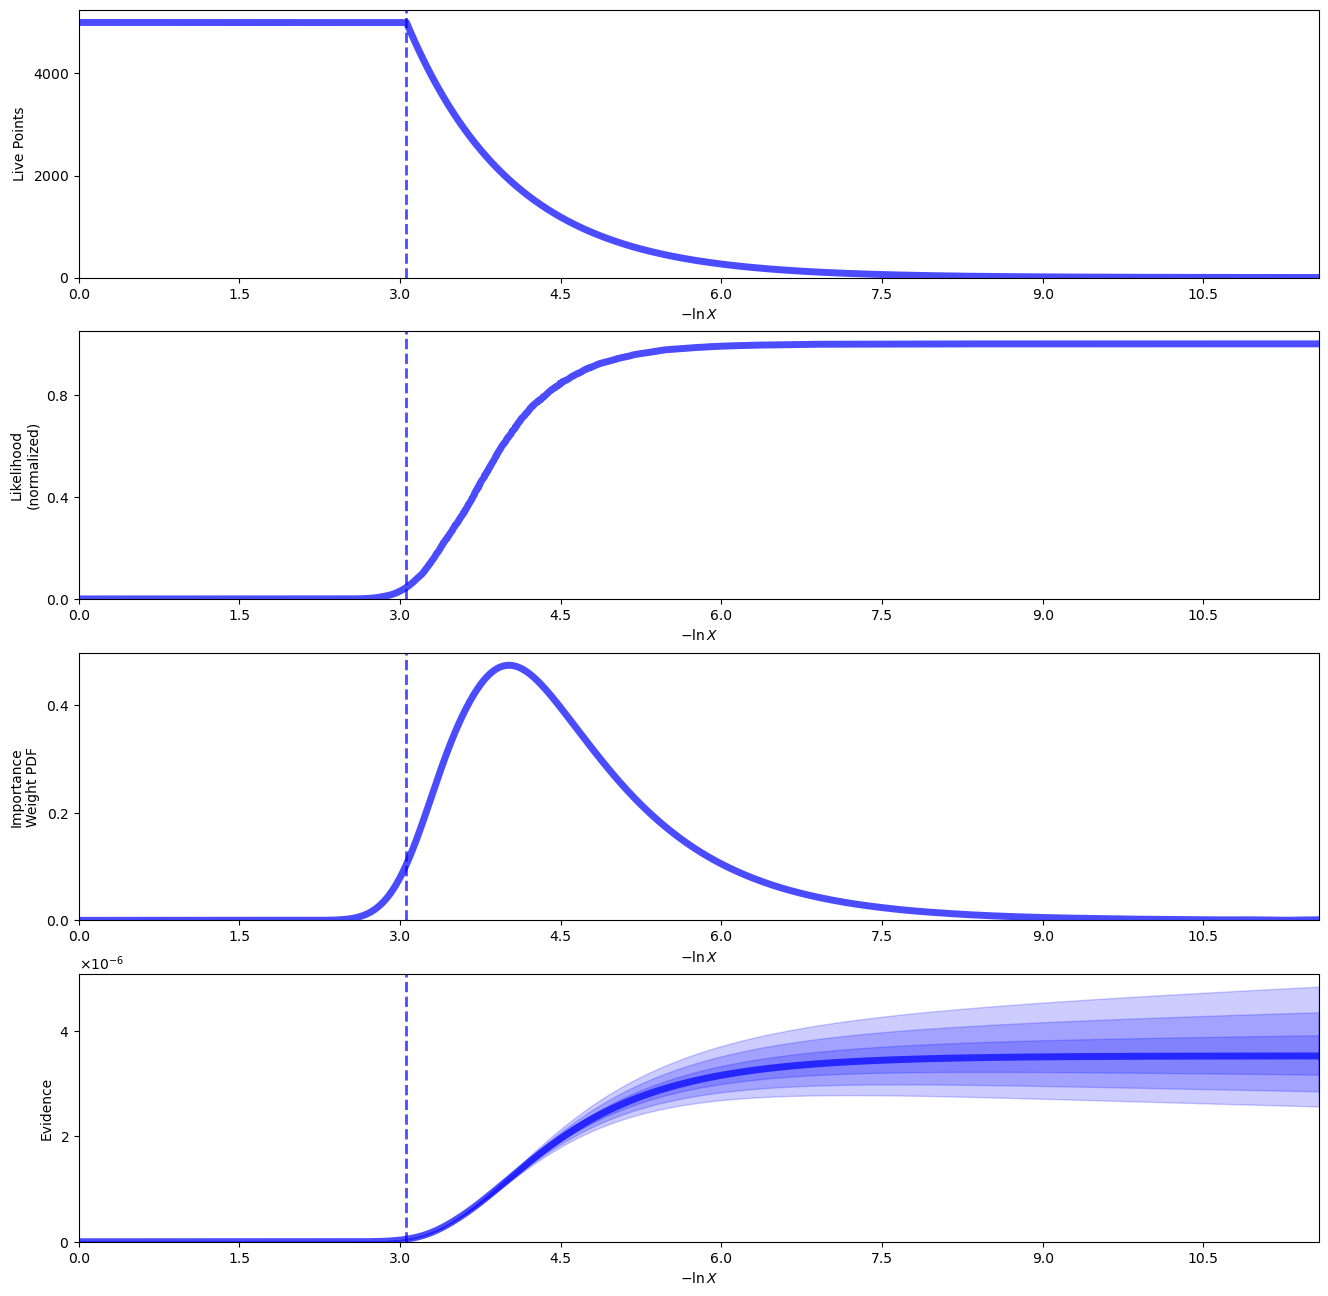

In [170]:
fig, axes = dyplot.runplot(nested_results2)  # summary (run) plot

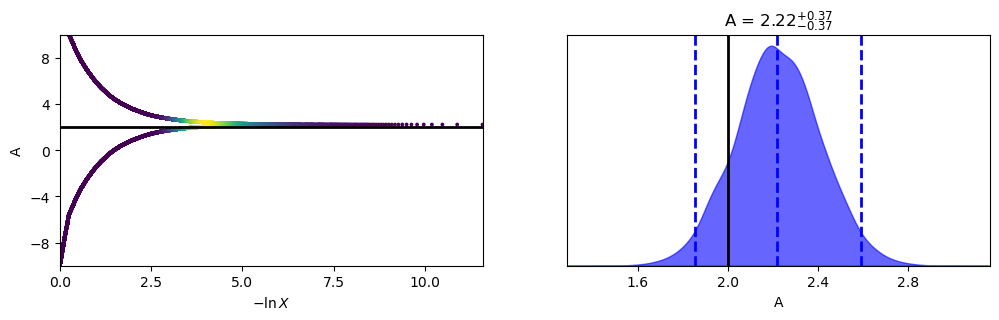

In [171]:
fig, axes = dyplot.traceplot(nested_results2, truths=[2],
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis',
                             labels=params[0])

calculate the evidence ratio, estimate the uncertainty based on an addition of the evidence uncertainties given by the sampler

In [191]:
evidence_ratio_in_favor_of_nuisance_model=np.exp(nested_results2.logz[-1]-nested_results.logz[-1])
plus_err=np.exp(nested_results2.logz[-1]-nested_results.logz[-1]+np.sqrt(nested_results2.logzerr[-1]**2+nested_results.logzerr[-1]**2))-evidence_ratio_in_favor_of_nuisance_model  #just adding assumed gaussian errors here....
minus_err=evidence_ratio_in_favor_of_nuisance_model-np.exp(nested_results2.logz[-1]-nested_results.logz[-1]-np.sqrt(nested_results2.logzerr[-1]**2+nested_results.logzerr[-1]**2))

In [193]:
print(f"Evidence ratio in favor of the nuisance model {evidence_ratio_in_favor_of_nuisance_model:.1f}+{plus_err:.1f}-{minus_err:.1f}")

Evidence ratio in favor of the nuisance model 926.5+255.7-200.4


this should be decisive evidence for the nuisance model as Bayes ratio is 1000+-200; so much larger than 100; yet the truth is actually from the more complex 3 parameter model